### Score Normalization
Ref: file:///Users/duane.hinkley/Zotero/storage/H5KPZK4R/score-normilization.html
1. Convert score to percentage
2. Normalize

In [32]:
%run '../lib/libraries.ipynb'

dython              0.6.1
tinydb              4.2.0


In [33]:
cleanDf = load_df('cleanDf')
cats = get_var_cats()

Display scores for assessement_id 748408

In [34]:
cleanDf.filter( F.col('assessment_id') == 748408 ).select('learner_assignment_attempt_id', 'points_possible_unweighted', 'final_score_unweighted').distinct().toPandas()

,learner_assignment_attempt_id,points_possible_unweighted,final_score_unweighted
0,1002584,48.0,44
1,1002763,48.0,41
2,1002598,48.0,39
3,1002637,48.0,43
4,1002558,48.0,44
5,1002614,48.0,40
6,1002702,48.0,32
7,1002681,48.0,11
8,1002648,48.0,46
9,1002587,48.0,37


Formula:

Z=(X-M)/S
z refers to the z-score,
M is the estimate of the population's mean,
S is the estimate of the population's standard deviation,
X is an individual score within the distribution having mean M and variance S.

percentage conversion

In [53]:
dfPercent = cleanDf.filter(~F.col('learner_assignment_attempt_id').isNull()).withColumn('percent', F.round( F.col('final_score_unweighted') / F.col('points_possible_unweighted') * 100) )

In [54]:
dfPercent.select('points_possible_unweighted', 'final_score_unweighted', 'percent').show()

+--------------------------+----------------------+-------+
|points_possible_unweighted|final_score_unweighted|percent|
+--------------------------+----------------------+-------+
|                       4.0|                     3|   75.0|
|                      10.0|                    10|  100.0|
|                      10.0|                    10|  100.0|
|                      20.0|                    18|   90.0|
|                      20.0|                    18|   90.0|
|                      20.0|                    18|   90.0|
|                       4.0|                     3|   75.0|
|                      10.0|                    10|  100.0|
|                       4.0|                     3|   75.0|
|                       4.0|                     3|   75.0|
|                      20.0|                    18|   90.0|
|                      20.0|                    18|   90.0|
|                      10.0|                     7|   70.0|
|                      20.0|            

mean and standard deviation

In [55]:
s = (dfPercent.groupBy("assessment_id")
  .agg(
      F.stddev_pop("percent").alias("sd"),
      F.avg("percent").alias("avg")))

s.show()

+-------------+------------------+------------------+
|assessment_id|                sd|               avg|
+-------------+------------------+------------------+
|       748408|20.231189734226806| 75.41176470588235|
|       661489| 39.04980772214684|40.168350168350166|
|       699380|               0.0|              40.0|
|       756753|10.657453489407915|  92.6470588235294|
|       687644| 17.57200928192567|41.714285714285715|
|       696973| 2.054804667656318| 72.66666666666667|
|       653848|               0.0|             100.0|
|       722540| 3.031088913245535|             98.25|
|       729577| 22.46185983823001| 51.19047619047619|
|       725646|               0.0|              10.0|
|       721940| 29.95469830623042| 62.22222222222222|
|       694324|               0.0|              75.0|
|       740994|               0.0|              71.0|
|       740960|               0.0|              82.0|
|       756773| 6.428243465332243| 93.63636363636364|
|       654733|             

Normalized score

In [56]:
dfPercent.join(F.broadcast(s), ["assessment_id"])

(dfPercent
    .join(F.broadcast(s), ["assessment_id"])
    .select(
        "assessment_id",
        "percent",
        ((dfPercent.percent - s.avg) / s.sd).alias('score')
)).show()

+-------------+-------+------------------+
|assessment_id|percent|             score|
+-------------+-------+------------------+
|       736105|   75.0| 0.880696034077061|
|       727353|  100.0| 0.872730216669552|
|       727353|  100.0| 0.872730216669552|
|       732131|   90.0|0.8248550491389581|
|       732131|   90.0|0.8248550491389581|
|       732131|   90.0|0.8248550491389581|
|       736105|   75.0| 0.880696034077061|
|       727353|  100.0| 0.872730216669552|
|       736105|   75.0| 0.880696034077061|
|       736105|   75.0| 0.880696034077061|
|       732131|   90.0|0.8248550491389581|
|       732131|   90.0|0.8248550491389581|
|       724303|   70.0|-0.787400787401181|
|       732131|   90.0|0.8248550491389581|
|       732131|   90.0|0.8248550491389581|
|       730403|   75.0|0.2721238827974116|
|       730403|   75.0|0.2721238827974116|
|       730403|   75.0|0.2721238827974116|
|       730403|   75.0|0.2721238827974116|
|       732131|   90.0|0.8248550491389581|
+----------

In [57]:
from scipy import stats

x = dfPercent.join(s, on=['assessment_id'], how='left').select(
        "assessment_id",
        "percent",
        ((dfPercent.percent - s.avg) / s.sd).alias('score')
).toPandas()

Is score distribution normal?

In [58]:
from scipy.stats import shapiro

stat, p = shapiro(x.score)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)


/Users/duane.hinkley/PycharmProjects/c772-capstone-project/venv/lib/python3.6/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


D’Agostino’s K^2 Test

In [59]:
from scipy.stats import normaltest

# normality test
stat, p = normaltest(x.score)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=nan, p=nan
Sample does not look Gaussian (reject H0)


Anderson-Darling Test

In [60]:
from scipy.stats import anderson

# normality test
result = anderson(x.score)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: nan
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


QQ Plot of scores for all assessments

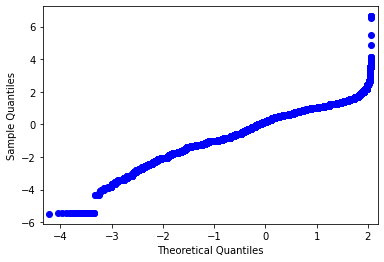

In [61]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

# q-q plot
qqplot(x.score, line='s')
pyplot.show()

QQ Plot of scores for one assessment

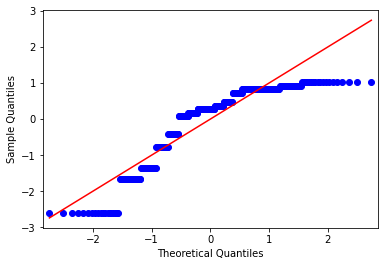

In [62]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

# q-q plot
qqplot(x[ x['assessment_id'] == 748408 ].score, line='s')
pyplot.show()

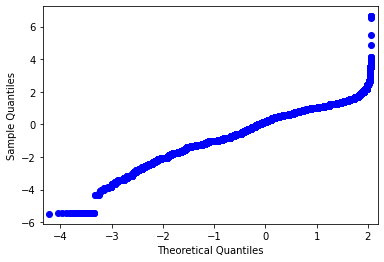

In [63]:
# q-q plot
qqplot(x.score, line='s')
pyplot.show()

histogram of scores for all assessments

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

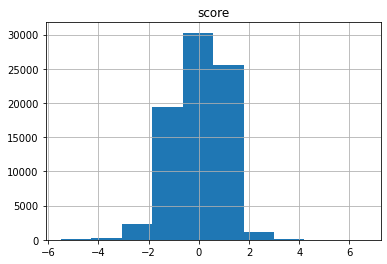

In [64]:
x.hist('score')

histogram of scores for one assessment

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

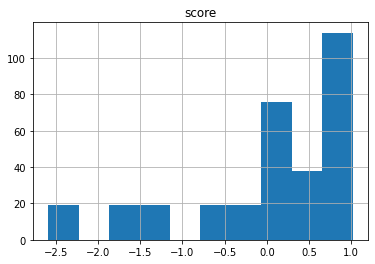

In [65]:
x[ x['assessment_id'] == 748408 ].hist('score')

histogram of percents for one assessment

In [ ]:
x[ x['assessment_id'] == 748408 ].hist('percent')

- Normaliztion is not different than percent

histogram of final score for one assessment

array([[<AxesSubplot:title={'center':'final_score_unweighted'}>]],
      dtype=object)

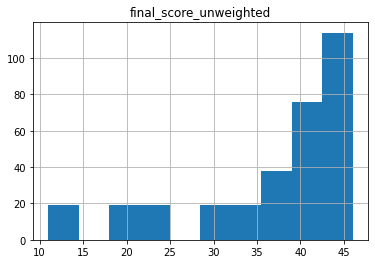

In [68]:
cleanDf.filter(F.col('assessment_id') == 748408).toPandas().hist('final_score_unweighted')

- Normaliztion is not different than score

